# CASA0007 QUANTITATIVE METHODS - COURSEWORK 1

This paper examines the opportunity for implementing gender-specific interventions in England to tackle child obesity. To do so, this paper will first study whether the prevalence of childhood obesity in England is gender-specific. This paper will then study whether the interventions have gender-specific effectiveness in tackling childhood obesity. This will provide insights as to whether and how the current interventions can be implemented in a gender-specific manner by targeting different interventions at different gender.

## Packages and Data

In [1]:
# Import packages

import numpy as np
import pandas as pd
import os
import scipy.stats as sps
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
# Import data
path = os.getcwd()
filename = 'coursework_1_data_2019.csv'
data_raw = pd.read_csv(os.path.join(path, filename))

## Presentation of Data

### Prevalance and percentage point change
- Compute prevalence for male and female in all years (2008, 2013, 2018) by normalizing the number of cases with the population size.
- Compute percentage-point change for male and female between 2008 and 2018.

In [3]:
# Set the years (2008, 2013, 2013), and gender (male, female)
years = ['2008', '2013', '2018']
genders = ['male', 'female']

# Initialize dataframe
data_rate = data_raw.loc[:,['local_authority_area']]

# For each gender
for gender in genders:
    # For each year
    for year in years:
        # Calculate the prevalence
        data_rate[year + '_' + gender] = \
        data_raw.loc[:, year + '_cases_' + gender] / data_raw.loc[:, year + '_pop_' + gender]
    # Calculate the precentage-point change in rate
    data_rate['delta_' + gender] = data_rate.loc[:, '2018_' + gender] - data_rate.loc[:, '2008_' + gender]

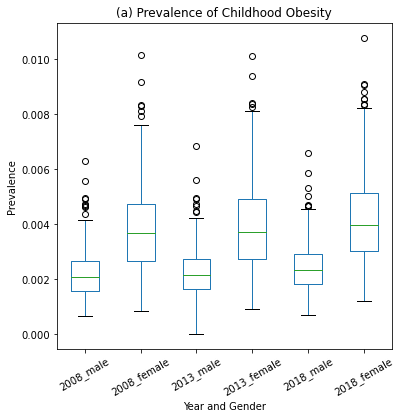

In [4]:
plt.figure(figsize=(6, 6))
plt.title('(a) Prevalence of Childhood Obesity')
plt.xlabel('Year and Gender')
plt.ylabel('Prevalence')
plt1a = data_rate.boxplot(['2008_male', '2008_female', '2013_male', '2013_female', '2018_male', '2018_female'], 
                         grid = False, rot = 30, widths = 0.5)

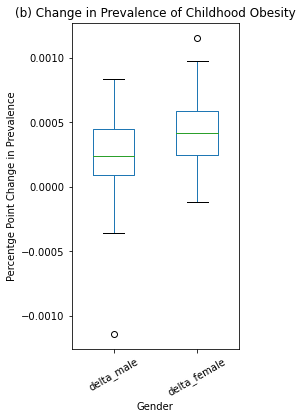

In [5]:
plt.figure(figsize=(3, 6))
plt.title('(b) Change in Prevalence of Childhood Obesity')
plt.xlabel('Gender')
plt.ylabel('Percentge Point Change in Prevalence')
plt1b = data_rate.boxplot(['delta_male', 'delta_female'], 
                  grid = False, rot = 30, widths = 0.5)

From the first boxplot, it **appears that females have higher prevalence of childhood obesity in England**.

### Budget, regions and local authority types

- Compute annual budget allocation per capita by normalizing the budget allocation by the average total population size across the three years.

In [6]:
# Initialize dataframe
data_bud = data_raw.loc[:,['local_authority_area']]

# Compute mean population
pop_mean = data_raw.loc[:,'2008_pop_total':'2018_pop_total'].mean(axis=1)

# Get ready to extract by budget columns
budget_cols = ['total_budget', 'clean_air', 'clean_environ', 'health_training', 'school_awareness', \
              'media_awareness', 'sub_counselling']

# Compute annual budget allocation per capita for each intervention
for col in budget_cols:
    data_bud['budget_'+ col] = data_raw.loc[:, col]/pop_mean

# Extract the region and authorities
data_bud = pd.merge(data_bud, data_raw[['local_authority_area', 'region', 'local_authority_type']])

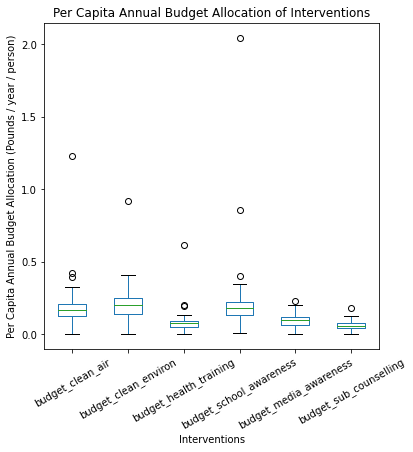

In [7]:
plt.figure(figsize=(6, 6))
plt.title('Per Capita Annual Budget Allocation of Interventions')
plt.xlabel('Interventions')
plt.ylabel('Per Capita Annual Budget Allocation (Pounds / year / person)')
plt2 = data_bud.boxplot(['budget_clean_air','budget_clean_environ','budget_health_training', 
                         'budget_school_awareness','budget_media_awareness', 'budget_sub_counselling'], 
                        grid = False, rot = 30, widths = 0.5)

## Methodology & Result

For all analyses, outliers were identified using Tukey fences. As there is no strong basis for omitting the outliers, all analyses were performed with and without outliers for comparison of outcomes.


In [8]:
# Define function to extract outliers based on Tukey fences

def re_outliers(df, col_name):

    '''
    Remove the outliers from dataframe based on Tukey fences

    :param df: the pandas dataframe
    :param col_name: the column being checked for outliers
    :return: (1) dataframe with outliers removed, and (2) outliers [local authority area] that have been removed
    '''

    # Initialize
    df_clean = df
    outliers_areas = []
    temp_areas = []

    while True:
    
        # Compute quartiles and IQR
        q1 = df_clean[col_name].quantile(0.25)
        q3 = df_clean[col_name].quantile(0.75)
        iqr = q3 - q1
        # Compute Tukey fences
        lo_tukey = q1 - 1.5*iqr
        hi_tukey = q3 + 1.5*iqr
    
        # Locate the rows and areas that are outside the Tukey fences
        outliers_rows = df_clean.index[(df_clean[col_name] < lo_tukey) | (df_clean[col_name] > hi_tukey)]
        
        if len(outliers_rows) > 0:
            temp_areas = df_clean['local_authority_area'][outliers_rows].values.tolist()
            outliers_areas = list(set(outliers_areas + temp_areas))
            df_clean = df_clean.drop(index = outliers_rows)
        else:
            break
    
    # Return both cleaned df and outlier areas
    return df_clean, sorted(outliers_areas)

In [9]:
# Define function to remove outliers in paired samples

def re_outliers_paired(df, col_name):

    '''
    Remove the outliers from dataframe based on Tukey fences in paired fashion for multiple columns

    :param df: the pandas dataframe
    :param col_name: the list of column(s) being checked for outliers
    :return: (1) dataframe with outliers removed, and (2) outliers [local authority area] that have been removed
    '''
    # initialize list to hold outlier areas
    outliers_area = []
    
    # For each column
    for col in col_name:
        # get outliers for the column
        temp_df, temp_outliers = re_outliers(df, col)
        # find all unique areas
        outliers_area = list(set(outliers_area + temp_outliers))
    
    outliers_area = sorted(outliers_area)
    
    # For all outlier areas
    df_clean = df
    for i in outliers_area:
        # Drop from df
        df_clean = df_clean.drop(df.index[df['local_authority_area'] == i])
    
    return df_clean, outliers_area

### #1: Gender-specificity of childhood obesity

To determine whether the prevalence of childhood obesity is higher in females, a one-tail paired t-test was performed with the hypotheses stated below at 5% significance level. The prevalence can be assumed to be identically and independently distributed, and follow a normal distribution given the large sample size.

- H0: Prevalence in females in the year <= Prevalence in males in the year
- H1: Prevalence in females in the year > Prevalence in males in the year

In [10]:
# Set significance level
alpha = 0.05

In [11]:
# Run hypothesis test for all years with all data (i.e. outliers not removed)

for year in years:
    print('TESTING:', format(year))
    
    # Run hypothesis test
    test_stat, p_value = sps.ttest_rel(data_rate[year+'_female'], data_rate[year+'_male'], alternative = 'greater')
    
    # Print conclusion
    print("p-value =", p_value)
    if p_value < alpha:
        print("Reject H0. Accept H1.")
    elif p_value >= alpha:
        print("No significant evidence to reject H0.")
        
    print('\n')

TESTING: 2008
p-value = 2.9510242285197693e-44
Reject H0. Accept H1.


TESTING: 2013
p-value = 2.5238335021332825e-44
Reject H0. Accept H1.


TESTING: 2018
p-value = 8.176252847016809e-46
Reject H0. Accept H1.




In [12]:
# Run hypothesis test for all years with outliers removed

for year in years:
    print('TESTING:', format(year))
    
    # Remove outliers first
    data_rate_clean, outliers_area = re_outliers_paired(data_rate, [year+'_female', year+'_male'])
    print('Outliers:', format(outliers_area))
    
    # Run hypothesis test
    test_stat, p_value = sps.ttest_rel(data_rate_clean[year+'_female'], data_rate_clean[year+'_male'],
                                       alternative = 'greater')
    
    # Print conclusion
    print("p-value =", p_value)
    if p_value < alpha:
        print("Reject H0. Accept H1.")
    elif p_value >= alpha:
        print("No significant evidence to reject H0.")

    print('\n')

TESTING: 2008
Outliers: ['Blackburn with Darwen', 'Bournemouth', 'Cornwall', 'Dudley', 'Nottingham', 'Nottinghamshire', 'Salford', 'Slough', 'Southampton', 'Stockport', 'Wakefield', 'Wigan', 'Wirral', 'Wolverhampton', 'York']
p-value = 6.071268409744873e-43
Reject H0. Accept H1.


TESTING: 2013
Outliers: ['Blackburn with Darwen', 'Bournemouth', 'Cornwall', 'Dudley', 'Isles of Scilly', 'Nottingham', 'Nottinghamshire', 'Salford', 'Slough', 'Southampton', 'Stockport', 'Wakefield', 'Wigan', 'Wirral', 'Wolverhampton', 'York']
p-value = 1.4282539587456106e-42
Reject H0. Accept H1.


TESTING: 2018
Outliers: ['Blackburn with Darwen', 'Bournemouth', 'Cornwall', 'Dudley', 'Nottingham', 'Nottinghamshire', 'Salford', 'Slough', 'Stockport', 'Wakefield', 'Wigan', 'Wirral', 'Wolverhampton', 'York']
p-value = 2.1775096640468667e-45
Reject H0. Accept H1.




As the p-values are below the significance level, H0 is rejected and H1 is accepted, regardless of whether outliers are included or excluded. **Since the prevalence of childhood obesity is significantly higher in females than males, there is value in exploring a gender-specific approach to tackle childhood obesity.**

### #2: Gender-specificity of interventions

To study whether there is a difference in the effectiveness of interventions in males and females, multiple regression was performed using the percentage-point change in prevalence against the annual budget allocation per capita for each intervention, region, and type of local authority. Region and type of local authority were included to control for any possible influence of these two variables in the regression. 

Prior to the regression, collinear variables were removed using Variance Inflation Factor.

In [13]:
# Define function to drop variables using VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [14]:
# Encode categorical data

data_bud_cat = pd.get_dummies(data_bud, columns = ['region', 'local_authority_type'])
data_bud_cat = data_bud_cat.drop(['region_London', 'local_authority_type_london_borough'], axis = 1)

In [16]:
# Drop collinear variables

data_bud_clean = drop_column_using_vif_(data_bud_cat.drop('local_authority_area', axis=1))

Dropping: budget_total_budget
Dropping: region_East Midlands
Dropping: local_authority_type_other_london
Dropping: local_authority_type_unitary_authority


Regression is performed using backward elimination to select the variables and with a p-value of 5% as the stopping criterion (Chowdhury and Turin, 2020).

In [17]:
# Define function to perform backwards regression using p-value as selection criterion

def back_regress(df_dep, df_ind, thresh=0.05):
    '''
    Performs regression with backwards selection of variables using AIC as selection criterion.

    :param df_dep, df_ind: the pandas dataframe containing dependent variable and indepdendent variables respectively.
    :return: the final regression model
    '''    
    
    # Initialize index_to_drop
    index_to_drop = []
    
    while True:
        # Get variables
        var = df_ind.columns.values.tolist()
        
        # Perform regressions
        if index_to_drop == 'const':
            reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
        else:
            reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
        
        # Find p-values for all variables
        df_pval = reg_model.pvalues
        #df_pval = pd.Series([reg_model.pvalues[i] for i in var], name='pvalue', index = var).to_frame()
        
        # If best (lowest) new AIC is lower than the current best, remove variable that improves AIC the most
        if df_pval.max() > thresh:
            # If there are multiple variables with best new AIC, choose the first one
            index_to_drop = df_pval.index[df_pval == df_pval.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            # Drop variable from df_ind
            if index_to_drop != 'const':
                df_ind = df_ind.drop(columns = index_to_drop)
        else:
            break
            
    # Perform regression with final set of variables
    if index_to_drop == 'const':
        reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
    else:
        reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
    
    return reg_model

PERFORMING REGRESSION ON:male
Dropping: budget_health_training
Dropping: budget_clean_air
Dropping: region_North West
Dropping: local_authority_type_metropolitan_borough
Dropping: budget_sub_counselling
Dropping: region_North East
                            OLS Regression Results                            
Dep. Variable:             delta_male   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     17.38
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           3.99e-19
Time:                        19:33:26   Log-Likelihood:                 1094.3
No. Observations:                 152   AIC:                            -2169.
Df Residuals:                     142   BIC:                            -2138.
Df Model:                           9                                         
Covariance Type:            nonrobust                     

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/

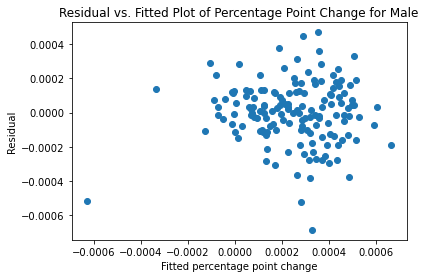



PERFORMING REGRESSION ON:female
Dropping: budget_health_training
Dropping: budget_sub_counselling
Dropping: local_authority_type_non_metropolitan_county
Dropping: budget_clean_air
Dropping: local_authority_type_metropolitan_borough
Dropping: region_North West


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/

Dropping: region_Yorkshire and the Humber
                            OLS Regression Results                            
Dep. Variable:           delta_female   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     9.515
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           1.68e-10
Time:                        19:33:26   Log-Likelihood:                 1079.8
No. Observations:                 152   AIC:                            -2142.
Df Residuals:                     143   BIC:                            -2114.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


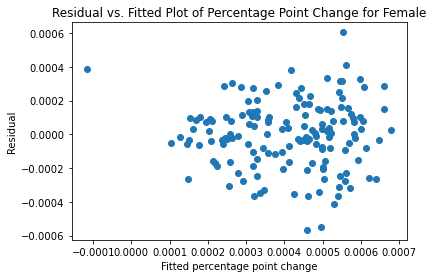

In [18]:
# Run regression for both gender with all data (i.e. outliers not removed)

for gender in genders:
    print(f'PERFORMING REGRESSION ON:{gender}')
    
    # Perform regression
    reg_model = back_regress(data_rate['delta_'+gender], data_bud_clean)
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted percentage point change')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot of Percentage Point Change for ' + gender.capitalize())
    plt.show()
    print('\n')

PERFORMING REGRESSION ON:MALE
Outliers: ['City of London', 'Haringey', 'Hartlepool', 'Isles of Scilly', 'Newcastle upon Tyne', 'Rutland', 'Slough', 'Thurrock']
Dropping: budget_health_training
Dropping: budget_sub_counselling
Dropping: budget_clean_environ
Dropping: local_authority_type_metropolitan_borough
Dropping: region_North West
Dropping: region_North East
Dropping: budget_clean_air
                            OLS Regression Results                            
Dep. Variable:             delta_male   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     15.79
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           2.86e-16
Time:                        19:33:34   Log-Likelihood:                 1047.7
No. Observations:                 144   AIC:                            -2077.
Df Residuals:                     135   BIC:           

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/

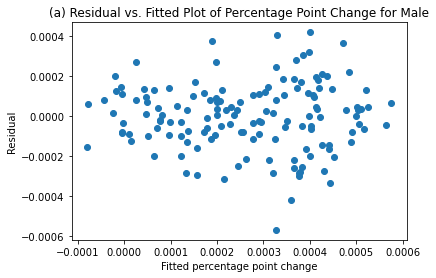



PERFORMING REGRESSION ON:FEMALE


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Outliers: ['Blackburn with Darwen', 'City of London', 'Haringey', 'Hartlepool', 'Isles of Scilly', 'Newcastle upon Tyne', 'Rutland', 'Slough', 'Thurrock']
Dropping: budget_clean_environ
Dropping: budget_sub_counselling
Dropping: budget_health_training
Dropping: local_authority_type_non_metropolitan_county
Dropping: budget_clean_air
                            OLS Regression Results                            
Dep. Variable:           delta_female   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     10.89
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           2.35e-13
Time:                        19:33:34   Log-Likelihood:                 1032.8
No. Observations:                 143   AIC:                            -2044.
Df Residuals:                     132   BIC:                            -2011.
Df Model:                         

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


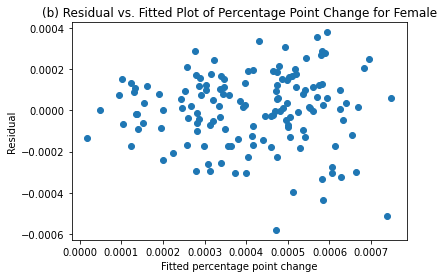

In [19]:
# Run regression for both gender with outliers removed

for gender in genders:
    print(f'PERFORMING REGRESSION ON:{gender.upper()}')
    
    # Remove outliers first
    df = pd.concat([data_rate[['local_authority_area','delta_'+gender]],data_bud_clean], axis=1)
    var = ['delta_'+gender,'budget_clean_air','budget_clean_environ','budget_health_training',
           'budget_school_awareness','budget_media_awareness','budget_sub_counselling']
    data_reout, outliers_area = re_outliers_paired(df, var)
    print('Outliers:', format(outliers_area))
    
    # Perform regression
    reg_model = back_regress(data_reout['delta_'+gender], 
                               data_reout.drop(['local_authority_area','delta_'+gender], axis = 1))
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted percentage point change')
    plt.ylabel('Residual')
    if gender == 'male':
        plt.title('(a) Residual vs. Fitted Plot of Percentage Point Change for ' + gender.capitalize())
    else:
        plt.title('(b) Residual vs. Fitted Plot of Percentage Point Change for ' + gender.capitalize())
    plt.show()
    print('\n')

From the plots of residuals against fitted values, there is a linear relationship, there is no outlier, and the variance is equal for all values of independent variables.

Among the interventions, only the intervention for raising awareness in schools had a negative coefficient and was associated with a reduction in the prevalence – every dollar spent per capita on this intervention was associated with a 0.05%-point reduction in the prevalence in males and a 0.1%-point reduction in females. **Since the effectiveness of the interventions are not gender-specific – the set of effective intervention(s) is the same for both genders (although it is more effective for females) – a gender-specific approach cannot be designed using the current set of six interventions**.

The inclusion/exclusion of outliers did not change this conclusion.

For comparison, multiple regression with all variables (i.e. no selection of variables) is performed.

PERFORMING REGRESSION ON:MALE
                            OLS Regression Results                            
Dep. Variable:             delta_male   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     11.03
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           4.26e-17
Time:                        19:33:40   Log-Likelihood:                 1098.3
No. Observations:                 152   AIC:                            -2165.
Df Residuals:                     136   BIC:                            -2116.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


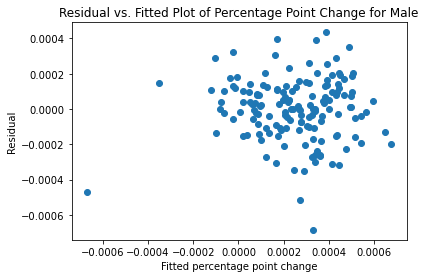



PERFORMING REGRESSION ON:FEMALE
                            OLS Regression Results                            
Dep. Variable:           delta_female   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     5.823
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           3.61e-09
Time:                        19:33:40   Log-Likelihood:                 1085.0
No. Observations:                 152   AIC:                            -2138.
Df Residuals:                     136   BIC:                            -2090.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


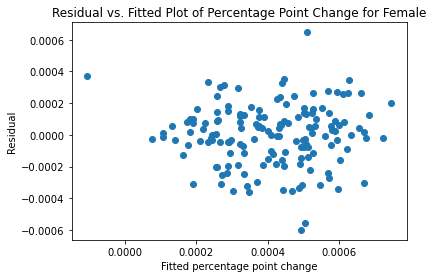

In [20]:
# Run regression without variable selection for both gender with all data (i.e. outliers not removed)

for gender in genders:
    print(f'PERFORMING REGRESSION ON:{gender.upper()}')
    
    # Perform regression
    reg_model = sm.OLS(endog=data_rate['delta_'+gender], exog=sm.add_constant(data_bud_clean)).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted percentage point change')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot of Percentage Point Change for ' + gender.capitalize())
    plt.show()
    print('\n')

PERFORMING REGRESSION ON:MALE
Outliers: ['City of London', 'Haringey', 'Hartlepool', 'Isles of Scilly', 'Newcastle upon Tyne', 'Rutland', 'Slough', 'Thurrock']
                            OLS Regression Results                            
Dep. Variable:             delta_male   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     9.357
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           1.83e-14
Time:                        19:33:47   Log-Likelihood:                 1053.5
No. Observations:                 144   AIC:                            -2075.
Df Residuals:                     128   BIC:                            -2027.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                  

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


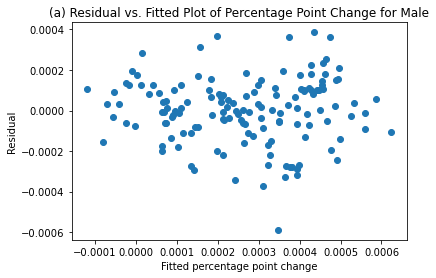



PERFORMING REGRESSION ON:FEMALE
Outliers: ['Blackburn with Darwen', 'City of London', 'Haringey', 'Hartlepool', 'Isles of Scilly', 'Newcastle upon Tyne', 'Rutland', 'Slough', 'Thurrock']


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:           delta_female   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     7.626
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           6.90e-12
Time:                        19:33:47   Log-Likelihood:                 1035.7
No. Observations:                 143   AIC:                            -2039.
Df Residuals:                     127   BIC:                            -1992.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

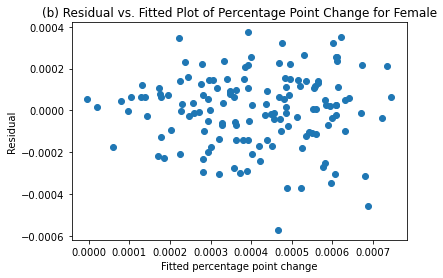

In [21]:
# Run regression without variable selection for both gender with outliers removed

for gender in genders:
    print(f'PERFORMING REGRESSION ON:{gender.upper()}')
    
    # Remove outliers first
    df = pd.concat([data_rate[['local_authority_area','delta_'+gender]],data_bud_clean], axis=1)
    var = ['delta_'+gender,'budget_clean_air','budget_clean_environ','budget_health_training',
           'budget_school_awareness','budget_media_awareness','budget_sub_counselling']
    data_reout, outliers_area = re_outliers_paired(df, var)
    print('Outliers:', format(outliers_area))
    
    # Perform regression
    reg_model = sm.OLS(endog=data_reout['delta_'+gender],
                       exog=sm.add_constant(data_reout.drop(['local_authority_area','delta_'+gender], axis = 1))).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted percentage point change')
    plt.ylabel('Residual')
    if gender == 'male':
        plt.title('(a) Residual vs. Fitted Plot of Percentage Point Change for ' + gender.capitalize())
    else:
        plt.title('(b) Residual vs. Fitted Plot of Percentage Point Change for ' + gender.capitalize())
    plt.show()
    print('\n')

As expected, when multiple regressions were performed with all variables, more interventions were found to be effective (i.e., interventions with negative coefficient) and adjusted R2 values are also higher. However, these new interventions have a p-value greater than the 5% significance level.